In [61]:
# Data Preprocessing
import pandas as pd
from pandas_datareader.data import DataReader
import ta
from ta.volume import VolumeWeightedAveragePrice
import yfinance as yf

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt

In [62]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-01"
symbol = "NFLX"
df = yf.download(symbol, start=start_date, end=end_date)
df.drop(columns=["Adj Close"], inplace=True)
df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,124.959999,128.190002,124.309998,127.489998,9437900
2017-01-04,127.489998,130.169998,126.550003,129.410004,7843600


In [63]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], 
                                  volume=df["Volume"], window=14, fillna=False)
df["VWAP"] = vwap.volume_weighted_average_price()
df.dropna(inplace=True)
df.head(2)

,Open,High,Low,Close,Volume,VWAP
Date,,,,,,
2017-01-23,138.649994,139.490005,137.309998,137.389999,7433900,133.484275
2017-01-24,138.110001,140.929993,137.029999,140.110001,7754700,134.279360


In [64]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100
df_mod = df_mod / df_mod.max()
df_mod = df_mod.dropna()
df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod.head()

,Open,High,Low,Close,Volume,VWAP,Close_Price
0,-0.026161,0.062555,-0.015894,0.117463,0.008021,0.104707,140.110001
1,0.130831,0.019779,0.114900,-0.024984,-0.012382,0.080842,139.520004
2,-0.016698,-0.007714,-0.030270,-0.023814,-0.030810,0.064711,138.960007
3,-0.047347,0.054927,0.027574,0.149012,0.070355,0.088945,142.449997
4,0.111261,-0.022114,-0.011215,-0.051231,-0.004497,0.064714,141.220001


In [65]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:700]
df_test = df_mod.copy()
df_test = df_test.iloc[700:]

<Axes: >

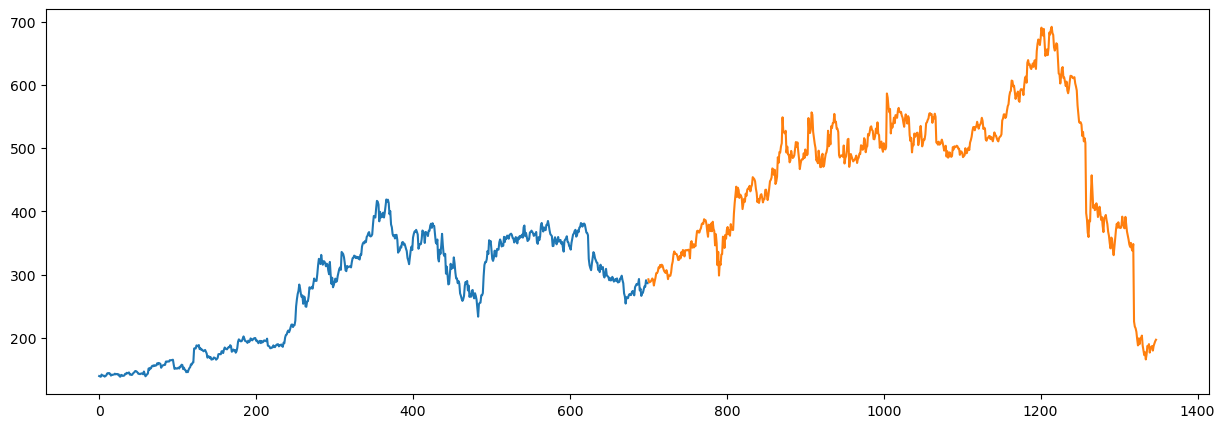

In [66]:
# View price behaviour
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot()
df_test["Close_Price"].plot()

In [67]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation

In [68]:
# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)
        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7, ), dtype=np.float32)
        
    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
    
    # Structure sign observation data
    def _next_observation(self):
        
        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()       
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "VWAP"].item()
        
        env_4 = 1 if self.long_short_ratio else 0
        
        obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])
        
        return obs
    
    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()
    
        self.current_step += 1
        
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False
        
        obs = self._next_observation()

        return obs, reward, done, {}
    
    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

In [69]:
# Test Environment
env = StockTradingEnv(df_train)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Ratio: ", env.num_trades_ratio)
    print("-------------------")

Initial Observation:  [-0.00328866  0.02620262  0.01978691  0.05242486 -0.00465784  0.02275827
  0.        ]

Action Taken:  0
Reward Received :  -0.015358155325218233
Next State:  [ 0.07190839  0.02061976 -0.03563551 -0.0445423   0.06330936  0.01971767
  1.        ]
Completed:  False
-------------------
Available Balance:  999.2492688541133
Realized Profit:  -0.750731145886685
Ratio:  0
-------------------

Action Taken:  1
Reward Received :  0.0022615925892835002
Next State:  [-0.11950765 -0.03900264  0.00165222  0.01953079 -0.05436373  0.0170718
  1.        ]
Completed:  False
-------------------
Available Balance:  998.1696062191081
Realized Profit:  -1.0796626350052094
Ratio:  0
-------------------

Action Taken:  2
Reward Received :  0.0022304074349366954
Next State:  [0.05870547 0.0151955  0.04570364 0.0066271  0.03403164 0.01778972
 1.        ]
Completed:  False
-------------------
Available Balance:  998.1696062191081
Realized Profit:  -1.0796626350052094
Ratio:  0
-----------

In [70]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [71]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [72]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [73]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value
    
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            
            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
            self.memory.clear_memory()

In [74]:
nv = StockTradingEnv(df_train)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [-0.00328866  0.02620262  0.01978691  0.05242486 -0.00465784  0.02275827
  1.        ]
Number of Actions:  2
Action Chosen:  1
Probability of Action:  -0.6937959790229797
Value of Action:  -0.003731062635779381
Next Oberservation [ 0.07190839  0.02061976 -0.03563551 -0.0445423   0.06330936  0.01971767
  0.        ]
Reward -0.004641844674781768
Done False
Info {}


In [75]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

... starting ...
... saving models ...
episide: 0, score: 43.16697003179068, avg score: 43.16697003179068, best_score: 43.16697003179068
episide: 1, score: 39.02492636417361, avg score: 41.095948197982146, best_score: 43.16697003179068
episide: 2, score: -71.27910917955273, avg score: 3.637595738803853, best_score: 43.16697003179068
episide: 3, score: 0.6565025809218328, avg score: 2.892322449333348, best_score: 43.16697003179068
... saving models ...
episide: 4, score: 352.3495845715141, avg score: 72.78377487376949, best_score: 72.78377487376949
... saving models ...
episide: 5, score: 228.98030107376292, avg score: 98.81652924043506, best_score: 98.81652924043506
episide: 6, score: -59.10941837530115, avg score: 76.25567958104418, best_score: 98.81652924043506
episide: 7, score: -31.98449313839091, avg score: 62.725657991114794, best_score: 98.81652924043506
episide: 8, score: -80.87154713616198, avg score: 46.770412976972935, best_score: 98.81652924043506
episide: 9, score: -31.608

episide: 81, score: -70.46072279646289, avg score: -70.57954500688662, best_score: 98.81652924043506
episide: 82, score: -70.46072279646289, avg score: -70.57954500688662, best_score: 98.81652924043506
episide: 83, score: -70.46072279646289, avg score: -70.57954500688662, best_score: 98.81652924043506
episide: 84, score: -70.46072279646289, avg score: -70.56276790255893, best_score: 98.81652924043506
episide: 85, score: -70.46072279646289, avg score: -70.56276790255893, best_score: 98.81652924043506
episide: 86, score: -70.46072279646289, avg score: -70.56276790255893, best_score: 98.81652924043506
episide: 87, score: -70.46072279646289, avg score: -70.56276790255893, best_score: 98.81652924043506
episide: 88, score: -70.46072279646289, avg score: -70.59837096134186, best_score: 98.81652924043506
episide: 89, score: -70.46072279646289, avg score: -70.59837096134186, best_score: 98.81652924043506
episide: 90, score: -70.46072279646289, avg score: -70.59837096134186, best_score: 98.81652

episide: 162, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 163, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 164, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 165, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 166, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 167, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 168, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 169, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 170, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 171, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652

episide: 244, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 245, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 246, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 247, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 248, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 249, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 250, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 251, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 252, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 253, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652

episide: 326, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 327, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 328, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 329, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 330, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 331, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 332, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 333, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 334, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 335, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652

episide: 408, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 409, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 410, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 411, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 412, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 413, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 414, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 415, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 416, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 417, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652

episide: 490, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 491, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 492, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 493, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 494, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 495, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 496, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 497, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 498, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652924043506
episide: 499, score: -70.46072279646289, avg score: -70.4607227964629, best_score: 98.81652

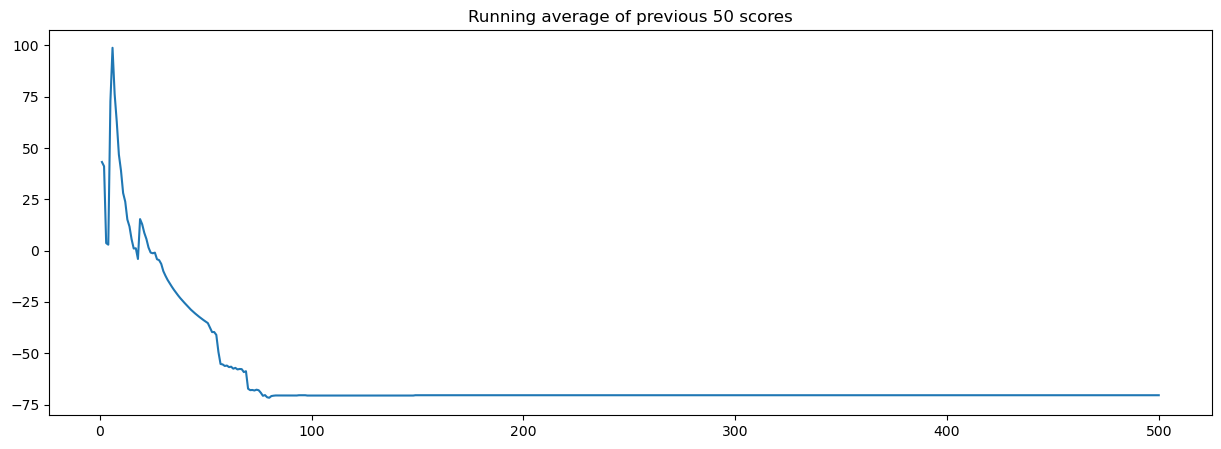

In [76]:
env = StockTradingEnv(df_train)
N = 20
batch_size = 5
n_epochs = 3
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
              alpha=alpha, n_epochs=n_epochs, 
              input_dims=env.observation_space.shape)

n_games = 500

figure_file = 'stock_training.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

print("... starting ...")
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
        observation = observation_
            
    # Save history
    score_history.append(score)
    avg_score = np.mean(score_history[-50:])
        
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
        
    print(f"episide: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")
            
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)

In [77]:
# agent.save_models()
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [78]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(5, len(reporting_df)):

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "VWAP"].item()
    
    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])
    
    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()
    
    print(np.argmax(probs), probs)
    
    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

1 [0.07531095 0.92468905]
1 [0.07403961 0.9259604 ]
1 [0.07553403 0.92446595]
1 [0.07346815 0.92653185]
1 [0.07592014 0.92407984]
1 [0.07251574 0.9274843 ]
1 [0.07805927 0.92194074]
1 [0.07798863 0.9220114 ]
1 [0.07299515 0.9270049 ]
1 [0.07656748 0.9234325 ]
1 [0.06515554 0.93484443]
1 [0.07176962 0.9282304 ]
1 [0.07820949 0.92179054]
1 [0.07024251 0.92975754]
1 [0.07662287 0.92337716]
1 [0.07428037 0.9257196 ]
1 [0.07421122 0.92578876]
1 [0.07163698 0.928363  ]
1 [0.07459321 0.9254068 ]
1 [0.07360803 0.92639196]
1 [0.07205109 0.9279489 ]
1 [0.06767317 0.93232685]
1 [0.06792633 0.93207365]
1 [0.07286873 0.9271313 ]
1 [0.07675877 0.92324126]
1 [0.07278698 0.927213  ]
1 [0.07291732 0.92708266]
1 [0.07379536 0.9262047 ]
1 [0.07085782 0.9291422 ]
1 [0.0759947 0.9240053]
1 [0.07459703 0.925403  ]
1 [0.07654688 0.92345315]
1 [0.07105403 0.92894596]
1 [0.07792351 0.92207646]
1 [0.0686022 0.9313978]
1 [0.06594434 0.9340556 ]
1 [0.07551028 0.92448974]
1 [0.07428572 0.92571425]
1 [0.07037929 0.

In [79]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[5:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)
        
df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,0.010003,294.179993,0.008951,0.075311,0.924689,-0.924689,1.000000,1.008951
1,0.143095,292.010010,-0.007376,0.074040,0.925960,-0.925960,1.006821,1.001575
2,-0.097577,283.109985,-0.030478,0.075534,0.924466,-0.924466,1.035235,0.971097
3,-0.179566,289.619995,0.022995,0.073468,0.926532,-0.926532,1.013228,0.994091
4,0.174063,295.029999,0.018680,0.075920,0.924080,-0.924080,0.995692,1.012771
...,...,...,...,...,...,...,...,...
638,-0.149750,180.339996,-0.037879,0.062170,0.937830,-0.937830,0.894862,0.851673
639,-0.063480,187.830002,0.041533,0.055193,0.944807,-0.944807,0.860007,0.893205
640,0.231380,191.399994,0.019007,0.070484,0.929516,-0.929516,0.844563,0.912212
641,0.241324,195.190002,0.019802,0.077096,0.922904,-0.922904,0.829018,0.932013


<Axes: >

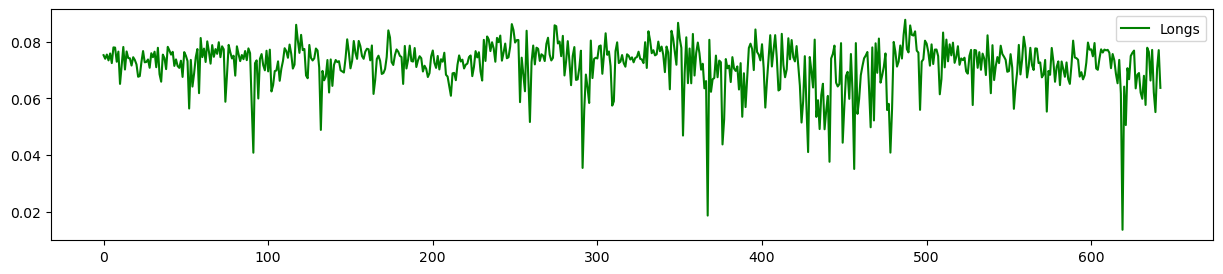

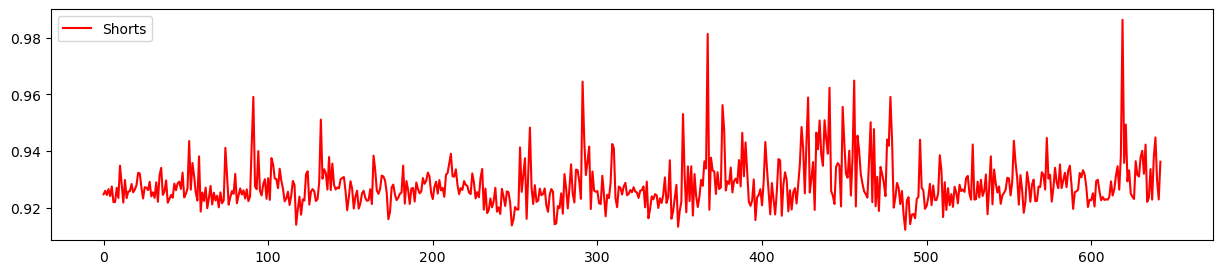

In [80]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")

<Axes: >

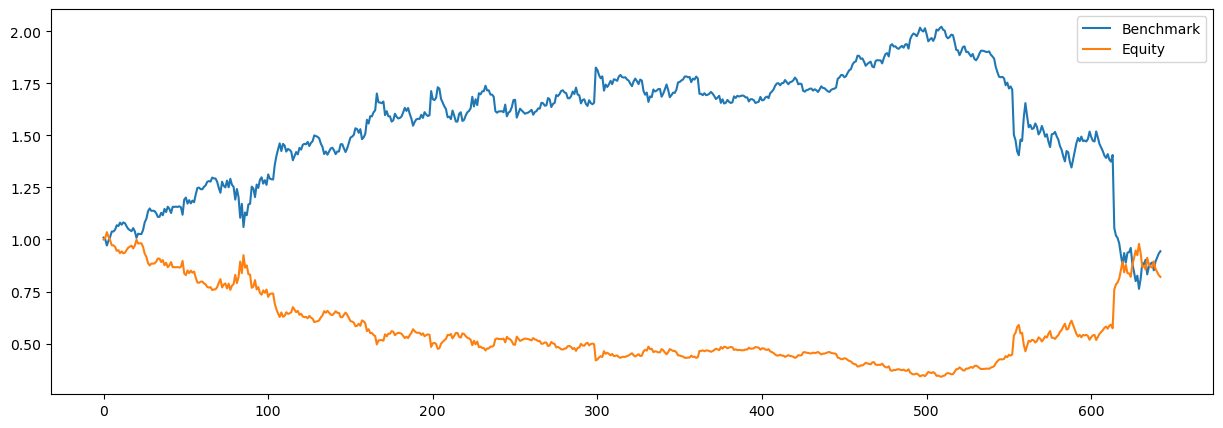

In [81]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()

In [82]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return -32.88%
ROI at -17.98%
